In [25]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import constants as cs
import Dates as dates 
import payoff as pf

%reload_ext autoreload
%autoreload 2


In [26]:

def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

data


[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2023-04-27,542.120544,237.429871
2023-04-28,546.263306,242.368103
2023-05-02,545.868835,239.800232
2023-05-03,574.079590,241.479218
2023-05-04,572.895935,242.071823
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [27]:
def multi_asset_gbm(data: pd.DataFrame, fdos) -> pd.DataFrame:
    """
    Simulates multiple asset paths under the risk-neutral measure using GBM.

    Params:
        data : DataFrame containing historical price data for each asset.
        fdos : First date of simulation (datetime object).
    
    Returns:
        sim_data : DataFrame containing simulated asset prices.
    """
    import numpy as np
    import pandas as pd
    
    # Constants (assuming they are defined elsewhere)
    # For example:
    # cs.ticker_list = ['Asset1', 'Asset2']
    # cs.interest_rate = 0.01  # Risk-free rate
    # cs.dt = 1/252  # Time step in years (daily steps)
    # cs.final_fixing_date = datetime object
    # cs.num_ticker = len(cs.ticker_list)
    
    try:
        # Prepare the log returns DataFrame
        log_returns_df = pd.DataFrame()
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker] / data[ticker].shift(1))
            log_returns_df[ticker] = log_returns
        log_returns_df.dropna(inplace=True)
        
    except Exception as e:
        raise Exception("Error at generating log returns.") from e

    try:
        # Compute the covariance matrix of log returns
        cov_matrix = log_returns_df.cov().values  # Shape: (num_assets, num_assets)
        # Compute the standard deviations (volatilities)
        vol_vector = np.sqrt(np.diag(cov_matrix))
        # Cholesky decomposition
        L = np.linalg.cholesky(cov_matrix)
        
    except Exception as e:
        raise Exception("Error at covariance matrix computation.") from e

    try:
        # Simulation parameters
        date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
        s0_vector = data.loc[fdos, cs.ticker_list].values  # Initial prices as NumPy array
        sim_window = dates.num_business_days(fdos, cs.final_fixing_date)
        dt = cs.dt  # Time step in years
        
        # Initialize the simulated data DataFrame
        sim_data = pd.DataFrame(index=date_list, columns=cs.ticker_list)
        sim_data.iloc[0] = s0_vector  # Set initial prices
        
        # Precompute drift terms
        drift = (cs.interest_rate - 0.5 * vol_vector ** 2) * dt
        
        # Generate random variables for all time steps and assets
        Z = np.random.normal(size=(sim_window - 1, cs.num_ticker))
        # Generate correlated random variables
        epsilon = Z @ L.T * np.sqrt(dt)  # Shape: (sim_window - 1, num_assets)
        
        # Simulate asset prices
        S = np.zeros((sim_window, cs.num_ticker))
        S[0] = s0_vector  # Initial prices
        
        for t in range(1, sim_window):
            S[t] = S[t - 1] * np.exp(drift + epsilon[t - 1])
            sim_data.iloc[t] = S[t]
        
    except Exception as e:
        raise Exception("Error during simulation.") from e

    return sim_data




In [28]:

simdata = multi_asset_gbm(data= data, fdos = cs.initial_fixing_date)
simdata

,LONN.SW,SIKA.SW
2023-04-27,542.120544,237.429871
2023-04-28,540.706114,237.234039
2023-05-02,541.345283,237.342719
2023-05-03,541.653612,237.523275
2023-05-04,543.002072,237.274737
...,...,...
2024-07-24,549.601661,240.28718
2024-07-25,549.161744,240.1789
2024-07-26,549.363433,240.543843
2024-07-29,549.162555,240.2625


In [29]:
def multi_asset_gbm_n_sims(plot: bool, plotasset: bool, nsims: int, data: pd.DataFrame, fdos) -> pd.DataFrame:
    """
    Simulate multiple asset paths under the GBM model for 'nsims' simulations starting from 'fdos'.

    Params:
        plot (bool): Whether to plot the combined simulations.
        plotasset (bool): Whether to plot the simulations for each asset separately.
        nsims (int): Number of simulations to run.
        data (pd.DataFrame): Historical data for assets.
        fdos: First date of simulation.

    Returns:
        sim_data_combine (pd.DataFrame): DataFrame containing simulated asset prices for all simulations.
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Assuming 'cs' and 'dates' are defined and accessible
    simulations = []
    
    # Get the list of dates for the simulation period
    date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
    
    # Realized price from initial fixing date to final fixing date
    realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    
    try:
        for n in range(nsims):
            # Run the simulation
            sim_data = multi_asset_gbm(data, fdos)
            # Ensure sim_data has the correct index (dates)
            sim_data.index = date_list
            # Rename columns to include the simulation number
            sim_data.columns = [f"{col}_sim{n+1}" for col in sim_data.columns]
            simulations.append(sim_data)
    except Exception as e:
        raise Exception("Error during simulation") from e

    # Combine all simulations along the columns
    sim_data_combine = pd.concat(simulations, axis=1)

    # Ensure the index is set to date_list
    sim_data_combine.index = date_list

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        # Plot the realized prices
        realised_price.plot(ax=ax, linewidth=2)
        # Plot the simulated paths
        sim_data_combine.plot(ax=ax, alpha=0.4, legend=False)
        plt.title('Simulated Paths with Realized Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()

    if plotasset:
        for asset in cs.ticker_list:
            # Select columns for the asset
            asset_columns = [col for col in sim_data_combine.columns if col.startswith(asset)]
            asset_paths = sim_data_combine[asset_columns]
            # Select the realized price for the asset
            realised_price_asset = realised_price[asset]  # Adjust the column name if necessary

            # Plot asset paths and realized price
            fig, ax = plt.subplots(figsize=(12, 6))
            asset_paths.plot(ax=ax, alpha=0.4, legend=False)
            realised_price_asset.plot(ax=ax, color='black', linewidth=2, label=f'Realized Price {asset}')
            ax.legend()
            plt.title(f'{asset} Paths under Multi Asset GBM')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.grid(True)
            plt.show()
            
    return sim_data_combine


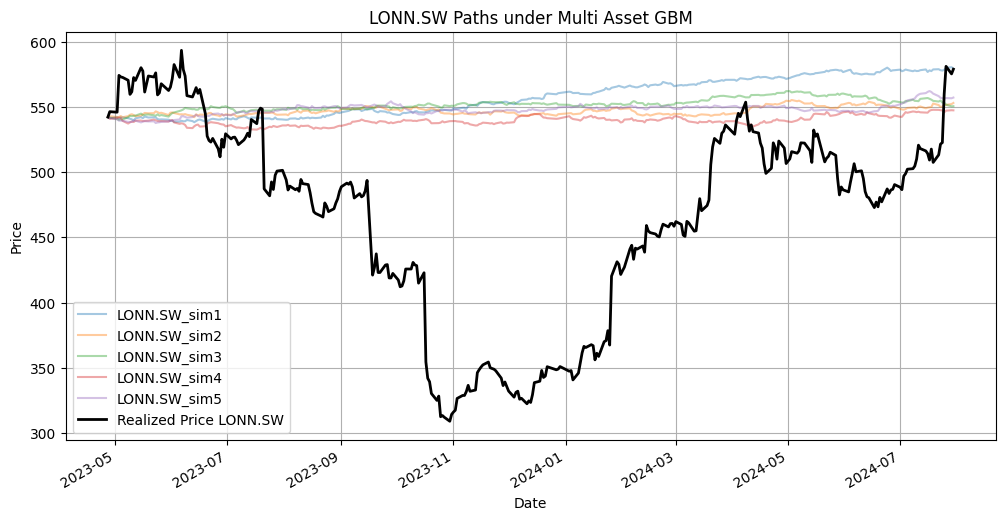

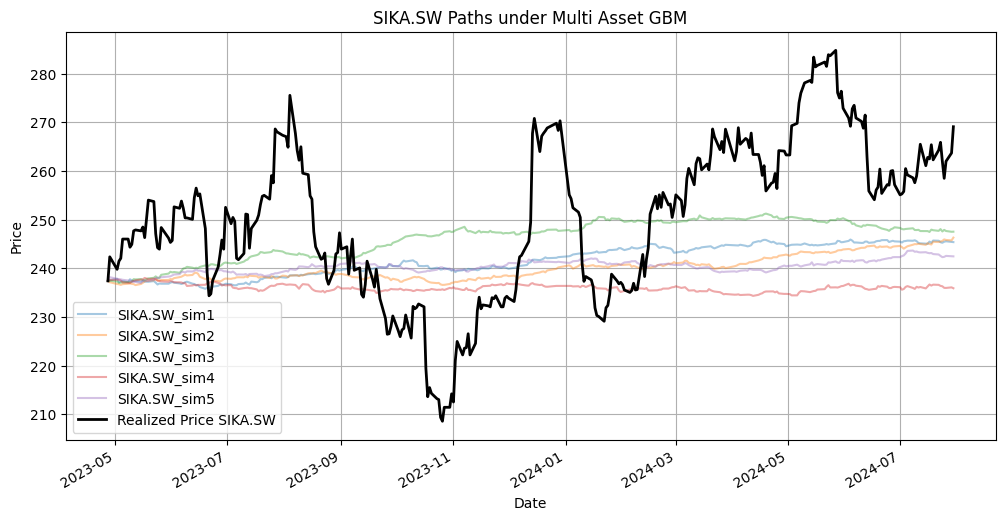

,LONN.SW_sim1,SIKA.SW_sim1,LONN.SW_sim2,SIKA.SW_sim2,LONN.SW_sim3,SIKA.SW_sim3,LONN.SW_sim4,SIKA.SW_sim4,LONN.SW_sim5,SIKA.SW_sim5
2023-04-27,542.120544,237.429871,542.120544,237.429871,542.120544,237.429871,542.120544,237.429871,542.120544,237.429871
2023-04-28,541.219717,237.552748,542.747312,237.151812,541.745395,237.431011,540.82545,237.640054,541.325833,238.180817
2023-05-02,542.218078,237.840468,542.193517,236.793154,540.598444,237.31622,541.314533,237.678827,540.390987,237.875529
2023-05-03,540.916732,237.184598,542.171691,236.730428,539.938875,237.006694,541.856241,237.679925,539.350544,237.748574
2023-05-04,541.895953,237.335512,542.905789,236.613367,540.383729,237.094411,541.474641,237.506392,539.389162,237.74002
...,...,...,...,...,...,...,...,...,...,...
2024-07-24,577.745741,245.259831,550.05717,245.643913,553.233102,247.585968,547.197196,236.320734,556.648367,242.306403
2024-07-25,578.324807,245.475381,551.610329,245.945033,553.278752,247.904183,545.755352,235.999093,556.225921,242.368794
2024-07-26,579.954426,245.562044,551.487428,245.836611,551.645055,247.676849,547.042366,235.981395,556.696155,242.56201
2024-07-29,580.303877,245.443891,552.09281,245.749751,550.365447,247.521817,547.379656,236.096873,556.537425,242.486019


In [30]:
sim_data_combined = multi_asset_gbm_n_sims(data = data, nsims = cs.n_sims, fdos = cs.initial_fixing_date, plot = False, plotasset=True)
sim_data_combined

In [31]:
lonza_path = sim_data_combined.iloc[:, ::2]
sika_path = sim_data_combined.iloc[:, 1::2]

In [32]:
lonza_path

,LONN.SW_sim1,LONN.SW_sim2,LONN.SW_sim3,LONN.SW_sim4,LONN.SW_sim5
2023-04-27,542.120544,542.120544,542.120544,542.120544,542.120544
2023-04-28,541.219717,542.747312,541.745395,540.82545,541.325833
2023-05-02,542.218078,542.193517,540.598444,541.314533,540.390987
2023-05-03,540.916732,542.171691,539.938875,541.856241,539.350544
2023-05-04,541.895953,542.905789,540.383729,541.474641,539.389162
...,...,...,...,...,...
2024-07-24,577.745741,550.05717,553.233102,547.197196,556.648367
2024-07-25,578.324807,551.610329,553.278752,545.755352,556.225921
2024-07-26,579.954426,551.487428,551.645055,547.042366,556.696155
2024-07-29,580.303877,552.09281,550.365447,547.379656,556.537425


In [33]:
params_product = {
    'Denomination': 1000,
    'Coupon_Rate': (0.08 / 252) ,  # Quarterly coupon payments
}

In [34]:
def payoff(paths1, paths2, params, fdos):
    """
    Calculates the payoff for each simulation based on the product conditions.
    
    Params:
        paths1: DataFrame of simulated paths for Lonza (columns: simulations)
        paths2: DataFrame of simulated paths for Sika (columns: simulations)
        params: Dictionary containing product parameters
        fdos: First date of simulation (pricing date)
    
    Returns:
        payoffs: Array of payoffs for each simulation
    """
    import numpy as np
    from dateutil.relativedelta import relativedelta

    def get_number_of_coupon_periods(start_date, end_date, frequency='quarterly'):
        delta = relativedelta(end_date, start_date)
        if frequency == 'quarterly':
            periods = delta.years * 4 + delta.months // 3
        elif frequency == 'monthly':
            periods = delta.years * 12 + delta.months
        else:
            periods = delta.years  # Assuming annual
        return periods

    def checkbarrier(lonza, sika, barrierS1, barrierS2):
        # Assuming daily monitoring
        barrier_breach = ((lonza <= barrierS1) | (sika <= barrierS2)).any()
        return barrier_breach

    def check_terminal(lonza, sika, initialS1, initialS2):
        terminal_condition = (lonza.iloc[-1] < initialS1) or (sika.iloc[-1] < initialS2)
        return terminal_condition

    lonza_path = paths1
    sika_path = paths2
    M = lonza_path.shape[1]  # Number of simulations
    payoffs = np.zeros(M)

    for i in range(M):  # For each simulation
        early_redeem = False
        lonza = lonza_path.iloc[:, i]
        sika = sika_path.iloc[:, i]
        early_observation_dates = dates.get_early_observation_dates(cs.initial_fixing_date, cs.final_fixing_date)
        
        for date_idx, t_date in enumerate(early_observation_dates):
            if (lonza.loc[t_date] >= cs.initialS1) and (sika.loc[t_date] >= cs.initialS2):
                # Early redemption
                # Assume settlement delay (e.g., 2 business days)
                settlement_delay = params.get('Settlement_Delay', 2)
                early_redemption_date = dates.add_business_days(t_date, settlement_delay)
                periods = get_number_of_coupon_periods(fdos, early_redemption_date)
                payoffs[i] = params['Denomination'] * (1 + params['Coupon_Rate'] * periods)
                early_redeem = True
                break  # Exit the early observation loop

        if not early_redeem:
            barrierhit = checkbarrier(lonza, sika, cs.barrierS1, cs.barrierS2)
            terminallower = check_terminal(lonza, sika, cs.initialS1, cs.initialS2)

            if not barrierhit and not terminallower:  # Best case scenario
                periods = get_number_of_coupon_periods(cs.initial_fixing_date, cs.final_fixing_date)
                payoffs[i] = params['Denomination'] * (1 + params['Coupon_Rate'] * periods)
            else:
                # Worst-case scenario
                perf_lonza = lonza.iloc[-1] / cs.initialS1
                perf_sika = sika.iloc[-1] / cs.initialS2
                worse_perf = min(perf_lonza, perf_sika)
                periods = get_number_of_coupon_periods(cs.initial_fixing_date, cs.final_fixing_date)
                payoffs[i] = params['Denomination'] * worse_perf
                payoffs[i] += params['Denomination'] * params['Coupon_Rate'] * periods

    return payoffs


In [35]:
date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
date_list = pd.Series(date_list)
date_list = date_list.tail(10).tolist()

import warnings
warnings.filterwarnings("ignore")

T = date_list
present_value_list = []
for fdos in T:  
    print(fdos)
    sim_T = multi_asset_gbm_n_sims(plot= False, plotasset=False, nsims=cs.n_sims, data = data, fdos=fdos)
    lonza_path = sim_T.iloc[:, ::2]
    sika_path = sim_T.iloc[:, 1::2]
    payoff_T = payoff(lonza_path, sika_path, params_product, fdos)
    print(payoff_T ,"at f{fdos}")
    expected_payoff = np.mean(payoff_T)
    present_value = expected_payoff * np.exp(-(0.018)/252*(dates.num_business_days(fdos, cs.final_fixing_date)))
    present_value_list.append(present_value)


2024-07-17 00:00:00
[927.33046452 922.80767719 926.71262118 926.63233743 927.14898184] at f{fdos}
2024-07-18 00:00:00
[946.42491724 942.15510174 943.9124321  942.07838025 941.99397772] at f{fdos}
2024-07-19 00:00:00
[927.08249444 920.95384027 920.4968867  929.02479576 927.56457619] at f{fdos}
2024-07-22 00:00:00
[931.28124609 935.01065369 936.72729194 938.68174764 936.26543911] at f{fdos}
2024-07-23 00:00:00
[950.94502735 941.65515805 953.42661147 949.97261827 953.74955806] at f{fdos}
2024-07-24 00:00:00
[952.11465134 950.24594797 956.51267317 950.5106786  955.47564426] at f{fdos}
2024-07-25 00:00:00
[1001.58730159 1001.58730159 1001.58730159 1001.58730159 1001.58730159] at f{fdos}
2024-07-26 00:00:00
[1001.58730159 1001.58730159 1001.58730159 1001.58730159 1001.58730159] at f{fdos}
2024-07-29 00:00:00
[1001.58730159 1001.58730159 1001.58730159 1001.58730159 1001.58730159] at f{fdos}
2024-07-30 00:00:00
[1001.58730159 1001.58730159 1001.58730159 1001.58730159 1001.58730159] at f{fdos}


<Axes: >

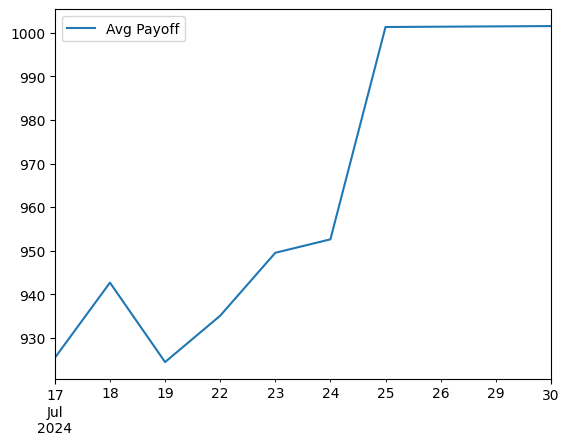

In [36]:
present_value_df = pd.DataFrame({'Avg Payoff': present_value_list}, index=T)
present_value_df.plot()